In [1]:
import pandas as pd
import seaborn as sns
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.backends.backend_pdf import PdfPages
import subprocess
from pylab import rcParams

In [2]:
#sns.set_context("paper") # doesn't work, rc={"figure.figsize": (5,5)})
rcParams['figure.figsize'] = 6, 4
rcParams['font.size'] = 7.0

In [3]:
def savefig(name, **kwargs):
    fn = "../../paper/fig/{}.pdf".format(name)
    pp = PdfPages(fn)
    pp.savefig(dpi=1200, bbox_inches="tight", **kwargs)
    pp.close()
    print("saving and cropping ", fn)
    subprocess.run(["pdfcrop", fn, fn])

In [4]:
_state = "State"
_power = "AC System Power [W]"
_count = "Number of Threads not in C2"
_frequency = "Frequency [MHz]"

ncores = 64
frequency = 2500

df = pd.read_csv("results/cstate_pause10_conway_10s_r3.csv")
df[_state] = df.shallow_state.apply(lambda x: {
    "C2": "C2 (all threads)",
    "C1": "C1",
    "POLL": "active (pause)",
}[x])
df[_power] = df.power
df[_count] = df.shallow_count
df[_frequency] = df.frequency

In [5]:
# sns.catplot(
#     data=df,
#     kind="strip",
#     y="power",
#     x="shallow_count",
#     hue="shallow_state",
#     row="base_state",
#     col="frequency"
# )

In [6]:
C6_power = df[(df.frequency==frequency) & (df.base_state=="C2") & (df.shallow_state=="C2")].power.mean()

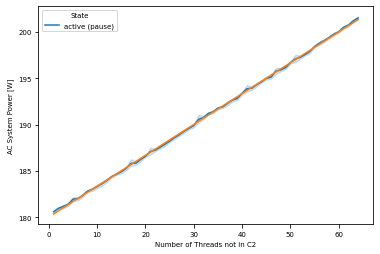

In [7]:
# Active, no HT
dfx = df[(df.frequency==frequency) & (df.base_state=="C2") &
         (df.shallow_state=="POLL") & (1 <= df.shallow_count) & (df.shallow_count <= 64)]
sns.lineplot(
    data=dfx,
    x=_count,
    y=_power,
    hue=_state,
    markers=False,
)
regression_C0_cores = LinearRegression().fit(dfx.shallow_count.values.reshape(-1, 1), dfx.power)
plt.plot(dfx.shallow_count, regression_C0_cores.predict(dfx.shallow_count.values.reshape(-1, 1)))

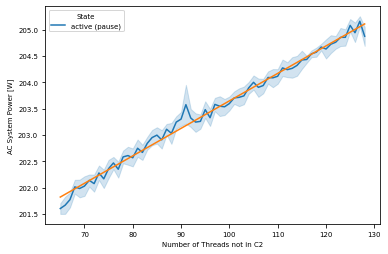

In [8]:
# Active, HT
dfx = df[(df.frequency==frequency) & (df.base_state=="C2") &
         (df.shallow_state=="POLL") & (ncores < df.shallow_count)]
ax = sns.lineplot(
    data=dfx,
    x=_count,
    y=_power,
    hue=_state,
    markers=False,
)
regression_C0_ht = LinearRegression().fit(dfx.shallow_count.values.reshape(-1, 1), dfx.power)
plt.plot(dfx.shallow_count, regression_C0_ht.predict(dfx.shallow_count.values.reshape(-1, 1)))

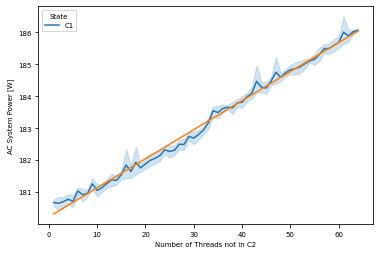

In [9]:
# Active, no HT
dfx = df[(df.frequency==frequency) & (df.base_state=="C2") &
         (df.shallow_state=="C1") & (1 <= df.shallow_count) & (df.shallow_count <= ncores)]
sns.lineplot(
    data=dfx,
    x=_count,
    y=_power,
    hue=_state,
    markers=False,
)
regression_C1_cores = LinearRegression().fit(dfx.shallow_count.values.reshape(-1, 1), dfx.power)
plt.plot(dfx.shallow_count, regression_C1_cores.predict(dfx.shallow_count.values.reshape(-1, 1)))

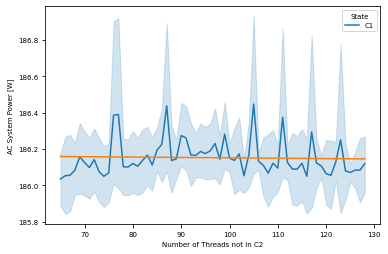

In [10]:
# Active, HT
dfx = df[(df.frequency==frequency) & (df.base_state=="C2") &
         (df.shallow_state=="C1") & (ncores < df.shallow_count)]
ax = sns.lineplot(
    data=dfx,
    x=_count,
    y=_power,
    hue=_state,
    markers=False,
)
regression_C1_ht = LinearRegression().fit(dfx.shallow_count.values.reshape(-1, 1), dfx.power)
plt.plot(dfx.shallow_count, regression_C1_ht.predict(dfx.shallow_count.values.reshape(-1, 1)))

In [11]:
print("Should match: ",
      regression_C1_cores.intercept_ + regression_C1_cores.coef_[0] * ncores,
      regression_C1_ht.intercept_ + regression_C1_ht.coef_[0] * ncores)

print("C6 power: ", C6_power)
print("C0 base power: ", regression_C0_cores.intercept_, ", +", regression_C0_cores.intercept_ - C6_power)
print("C0 first core: ", (regression_C0_cores.intercept_ + regression_C0_cores.coef_[0]), ", +", (regression_C0_cores.intercept_ + regression_C0_cores.coef_[0]) - C6_power)
print("C0 per core: ", regression_C0_cores.coef_[0])
print("C0 per addl thread: ", regression_C0_ht.coef_[0])
print("C1 base power: ", regression_C1_cores.intercept_, ", +", regression_C1_cores.intercept_ - C6_power)
print("C1 first core: ", (regression_C1_cores.intercept_ + regression_C1_cores.coef_[0])  , ", +", (regression_C1_cores.intercept_ + regression_C1_cores.coef_[0]) - C6_power)
print("C1 per core: ", regression_C1_cores.coef_[0])
print("C1 per addl thread: ", regression_C1_ht.coef_[0])


Should match:  186.04866371210568 186.1585214877005
C6 power:  99.05029410605106
C0 base power:  180.04105346912982 , + 80.99075936307877
C0 first core:  180.3734686943051 , + 81.32317458825405
C0 per core:  0.3324152251752931
C0 per addl thread:  0.05217096804467865
C1 base power:  180.22454082128792 , + 81.17424671523686
C1 first core:  180.31554274145694 , + 81.26524863540588
C1 per core:  0.09100192016902735
C1 per addl thread:  -0.00020527553755045916


saving and cropping  ../../paper/fig/cstate-power-2500.pdf


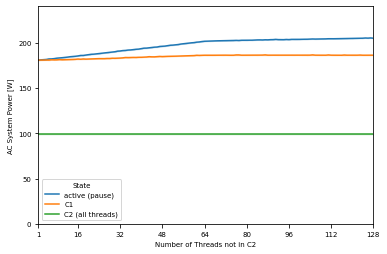

In [12]:
rcParams['figure.figsize'] = 6, 4
dfx = df[(df.frequency==frequency) & (df.base_state=="C2") & (df.shallow_state != "C2")]

df_extra = deepcopy(df[(df.frequency==frequency) & (df.base_state=="C2") & (df.shallow_state=="C2")])
df_extra[_count] = 1
dfx = dfx.append(df_extra)
df_extra[_count] = ncores * 2
dfx = dfx.append(df_extra)
ax = sns.lineplot(
    data=dfx,
    x=_count,
    y=_power,
    hue=_state,
    markers=False,
)
ax.set_xlim(1,ncores*2)
ax.set_xticks([1] + list(range(16,2*ncores+16,16)))
ax.set_ylim(0,240)

savefig("cstate-power-2500")


saving and cropping  ../../paper/fig/cstate-power-allfreq.pdf


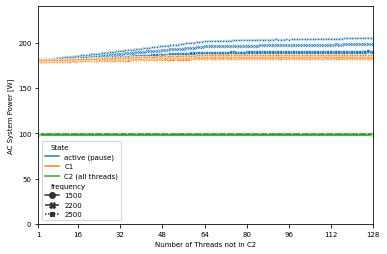

In [13]:
rcParams['figure.figsize'] = 6, 4
dfx = df[(df.base_state=="C2") & (df.shallow_state != "C2")]

df_extra = deepcopy(df[(df.base_state=="C2") & (df.shallow_state=="C2")])
df_extra[_count] = 1
dfx = dfx.append(df_extra)
df_extra[_count] = ncores * 2
dfx = dfx.append(df_extra)
ax = sns.lineplot(
    data=dfx,
    x=_count,
    y=_power,
    hue=_state,
    style="frequency",
    markers=True,
    markeredgewidth=0.5,
    markersize=4.0,
    # fillstyle='none'
)
ax.set_xlim(1,ncores*2)
ax.set_xticks([1] + list(range(16,2*ncores+16,16)))
ax.set_ylim(0,240)

savefig("cstate-power-allfreq")


saving and cropping  ../../paper/fig/cstate-power-allfreq.pdf


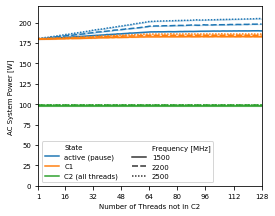

In [21]:
rcParams['figure.figsize'] = 4, 3.3

dfx = df[(df.base_state=="C2") & (df.shallow_state != "C2")]

df_extra = deepcopy(df[(df.base_state=="C2") & (df.shallow_state=="C2")])
df_extra[_count] = 1
dfx = dfx.append(df_extra)
df_extra[_count] = ncores * 2
dfx = dfx.append(df_extra)
ax = sns.lineplot(
    data=dfx,
    x=_count,
    y=_power,
    hue=_state,
    style=_frequency,
    markers=False,
)
ax.set_xlim(1,ncores*2)
ax.set_xticks([1] + list(range(16,2*ncores+16,16)))
ax.set_ylim(0,220)
ax.legend(
    ncol=2,
)
savefig("cstate-power-allfreq")
